In [1]:
import pandas as pd
import numpy as np
# import pygaze
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy
import glob
from tqdm import tqdm
from sklearn.cluster import DBSCAN
import detectors
import gazeplotter
from collections import defaultdict
# import local lib
import eye_metrics_utils
import data_utils
import gaze_entropy

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, mean_squared_log_error


In [2]:
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

In [3]:
def run_all(df_data):
    df_x = df_data.copy()
    if (data_utils.check_percentage_null(df_x) < 0.5): # if missing value > 50%, remove
        return None
    
    time = np.array(df_data['Start Time (secs)'].tolist())

    Efix = eye_metrics_utils.detect_fixations(df_x)
    Eblk = eye_metrics_utils.detect_blinks(df_x)
    Esac = eye_metrics_utils.detect_saccades(df_x)
    Emsac = eye_metrics_utils.detect_microsaccades(df_x)
#     print(Efix)
    X = np.array(Efix).T[3:].T
    Hs, Ht = gaze_entropy.entropy(X)
    total_time = time[-1] - time[0]
    
    return Efix, Hs, Ht, total_time, Eblk, Esac, Emsac
    

In [4]:
csv_files = glob.glob("data/*.csv")

In [5]:
csv_files_one = [v for v in csv_files if "One Gaze-Vergence" in v]
csv_files_two = [v for v in csv_files if "Two Gaze-Vergence" in v]
csv_files_three = [v for v in csv_files if "Three Go-Around Gaze-Vergence" in v]

In [6]:
df_par = pd.read_csv("participant.csv")
par_id_arr = [v[-3:] for v in df_par['ID'].tolist()]
flight_exp_arr = df_par['Flight_hour'].tolist()

for i,e in zip(par_id_arr, flight_exp_arr):
    print(i, e)

032 10
027 18
031 26
028 28
004 35
008 35
010 35
029 40
003 42
007 49
023 50
021 63
006 90
019 98
022 100
015 133
016 200
014 155
005 180
025 200
002 220
001 230
020 230
011 300
017 420
013 23
024 28
018 116
026 150
012 175
009 220
033 1300


In [7]:
trials = []
# for csv_files in [csv_files_one, csv_files_two, csv_files_three]:
for csv_files in [csv_files_two]:

    part = defaultdict(dict)
    for csv in csv_files:
        par_id = csv[14:17]
        if par_id not in par_id_arr:
            continue
        ret = defaultdict(list)
        df_data = pd.read_csv(csv)
        print(csv, len(df_data))
        for v in data_utils.data_slicing(df_data, window_length = 1800, stride = 1800, min_length=1200):
            r = run_all(v)
            if r != None:
                Efix, Hs, Ht, total_time, Eblk, Esac, Emsac = r
                ret["Eblk"].append(Eblk)
                ret["Efix"].append(Efix)
                ret["Esac"].append(Esac)
                ret["Emsac"].append(Emsac)
                ret["Hs"].append(Hs)
                ret["Ht"].append(Ht)
                ret["total_time"].append(total_time)
        part[par_id] = ret
    trials.append(part)

data\PISSS_ID_001_Approach Two Gaze-Vergence.csv 9554
data\PISSS_ID_002_Approach Two Gaze-Vergence.csv 9430
data\PISSS_ID_003_Approach Two Gaze-Vergence.csv 9368
data\PISSS_ID_004_Approach Two Gaze-Vergence.csv 9862
data\PISSS_ID_005_Approach Two Gaze-Vergence.csv 9245
data\PISSS_ID_006_Approach Two Gaze-Vergence.csv 9739
data\PISSS_ID_007_Approach Two Gaze-Vergence.csv 9677
data\PISSS_ID_008_Approach Two Gaze-Vergence.csv 9923
data\PISSS_ID_009_Approach Two Gaze-Vergence.csv 9243
data\PISSS_ID_010_Approach Two Gaze-Vergence.csv 9923
data\PISSS_ID_011_Approach Two Gaze-Vergence.csv 9492
data\PISSS_ID_012_Approach Two Gaze-Vergence.csv 9431
data\PISSS_ID_013_Approach Two Gaze-Vergence.csv 8691
data\PISSS_ID_014_Approach Two Gaze-Vergence.csv 9307
data\PISSS_ID_015_Approach Two Gaze-Vergence.csv 8812
data\PISSS_ID_016_Approach Two Gaze-Vergence.csv 8259
data\PISSS_ID_017_Approach Two Gaze-Vergence.csv 9184
data\PISSS_ID_018_Approach Two Gaze-Vergence.csv 8937
data\PISSS_ID_019_Approach T

In [57]:
df_x = pd.DataFrame()
for trial in trials:
    for i, par_id in enumerate(par_id_arr):
#         print(par_id)
        if len(trial[par_id]) == 0:
            continue
        fix_dur = []
        for p in trial[par_id]['Efix']:
            fix_dur = np.append(fix_dur,np.mean(np.array(p).T[2]))

        Hs = trial[par_id]['Hs']
        Ht = trial[par_id]['Ht']

        fix_rate = np.array([len(v) for v in trial[par_id]['Efix']])/np.array(trial[par_id]['total_time'])
        blk_rate = np.array([len(v) for v in trial[par_id]['Eblk']])/np.array(trial[par_id]['total_time'])
        sac_rate = np.array([len(v) for v in trial[par_id]['Esac']])/np.array(trial[par_id]['total_time'])
        msac_rate = np.array([len(v) for v in trial[par_id]['Emsac']])/np.array(trial[par_id]['total_time'])
        
        exp = flight_exp_arr[i] * np.ones_like(Hs)
        df = pd.DataFrame(zip(fix_dur, Hs, Ht, fix_rate, blk_rate, sac_rate, msac_rate, exp), 
                        columns=["fix_dur", "Hs", "Ht", "fix_rate", "blk_rate", "sac_rate", "msac_rate", "exp"])
        df_x = pd.concat([df_x, df])
    
df_x.reset_index()

,index,fix_dur,Hs,Ht,fix_rate,blk_rate,sac_rate,msac_rate,exp
0,0,0.775423,1.354584,1.297595,1.060869,0.068443,0.855540,1.368863,10.0
1,1,0.614045,1.897849,1.517279,1.301890,0.000000,0.890767,1.610233,10.0
2,2,0.612309,1.660072,1.397686,1.233369,0.068521,0.993547,1.747273,10.0
3,3,0.499124,2.033565,1.466746,1.439080,0.068528,1.096442,1.850245,10.0
4,0,0.370196,1.924764,1.289418,1.918695,0.000000,0.959348,2.980830,18.0
...,...,...,...,...,...,...,...,...,...
131,0,0.260355,2.128343,1.625371,2.121872,0.034224,1.266278,4.620205,220.0
132,1,0.291375,2.273690,1.579292,1.713120,0.102787,1.130659,3.940177,220.0
133,2,0.201198,2.227963,1.607653,1.747388,0.205575,1.027875,4.282813,220.0
134,3,0.146083,1.543022,1.426363,0.890823,0.616723,0.925085,4.419851,220.0


In [58]:
print(len(df_x))
df_x = df_x[~(df_x.iloc[:,:7] == 0).any(axis=1)]
len(df_x)

136


122

In [10]:
X = df_x[['fix_dur', 'Hs', 'Ht', "fix_rate", "blk_rate", "sac_rate", "msac_rate"]].values
# X = df_x[['fix_dur', 'Hs', "Ht"]].values

y = df_x[['exp']].values
X = StandardScaler().fit_transform(X)

# X = X[:,1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=5)

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


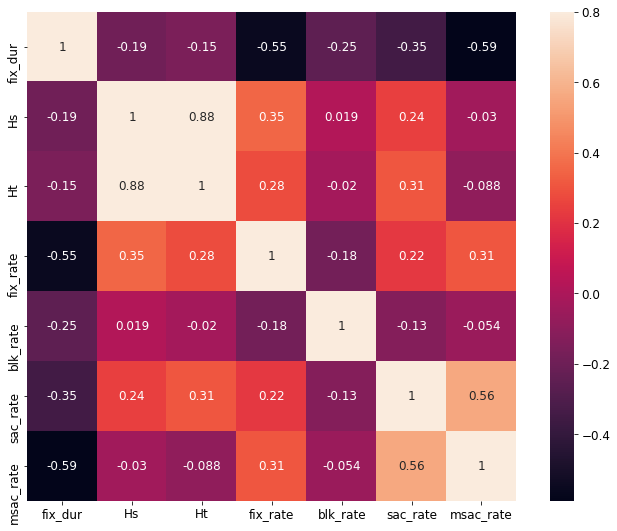

In [11]:
df_train = df_x[['fix_dur', 'Hs', 'Ht', "fix_rate", "blk_rate", "sac_rate", "msac_rate"]]
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, annot=True, vmax=.8, square=True);

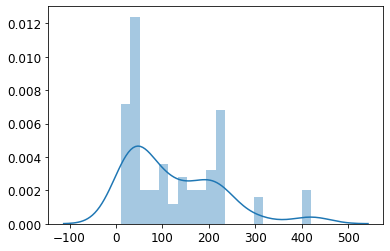

In [12]:
sns.distplot(y, bins = 20);

In [13]:
print("skew:", df_x['exp'].skew())
print("kurtosis:", df_x['exp'].kurt())

skew: 1.1224001692449155
kurtosis: 0.9541187399080888


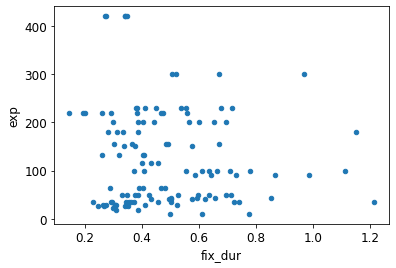

In [14]:
var = 'fix_dur'
data = pd.concat([df_x['exp'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='exp');

## deep learning

In [37]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

2.0.0


In [75]:
dataset = df_x.copy().reset_index()

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)


train_stats = train_dataset.describe()
train_stats.pop("exp")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
index,98.0,1.795918,1.346696,0.000000,1.000000,2.000000,3.000000,4.000000
fix_dur,98.0,0.497479,0.206424,0.146083,0.344831,0.452767,0.611564,1.211964
Hs,98.0,1.654972,0.496802,0.791858,1.310436,1.597426,2.016577,2.714576
Ht,98.0,1.335623,0.336212,0.637441,1.004953,1.410938,1.592441,1.902647
fix_rate,98.0,1.353009,0.365148,0.685276,1.096511,1.284953,1.593295,2.158386
blk_rate,98.0,0.240190,0.228687,0.034250,0.102784,0.171295,0.342602,1.165005
sac_rate,98.0,0.945705,0.341810,0.308372,0.728178,0.925133,1.130640,2.981036
msac_rate,98.0,2.355710,1.010352,0.788067,1.695876,2.192690,2.569642,8.223547


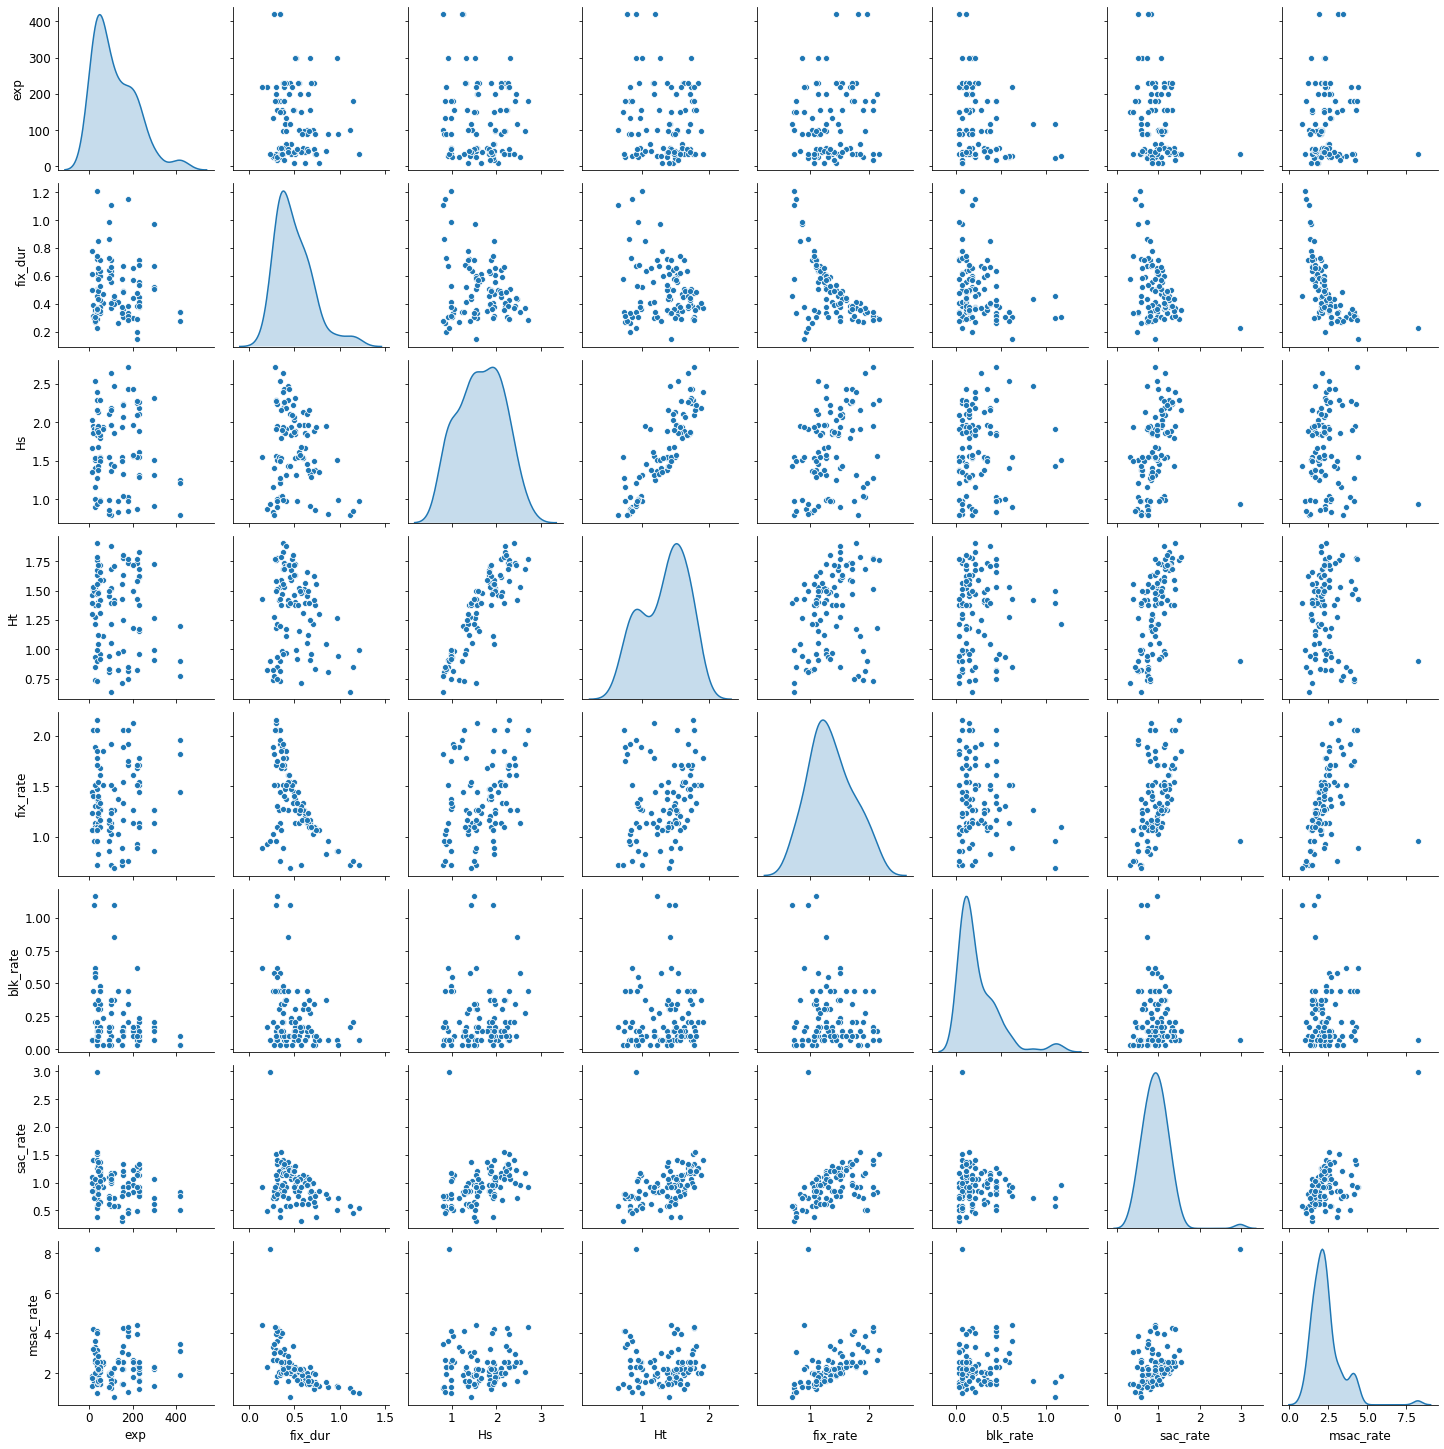

In [48]:
sns.pairplot(train_dataset[["exp", "fix_dur", "Hs", "Ht", "fix_rate", "blk_rate", "sac_rate", "msac_rate"]], diag_kind="kde")

In [76]:
train_labels = train_dataset.pop('exp')
test_labels = test_dataset.pop('exp')

In [77]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [109]:
def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [118]:
model = build_model()

In [119]:
train_labels = np.asarray(train_labels)


In [120]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch.values)
example_result

array([[ 0.09045378],
       [-0.02379203],
       [ 0.05395069],
       [ 0.6610454 ],
       [ 0.00710725],
       [ 0.2019491 ],
       [ 0.0952118 ],
       [ 0.40472344],
       [-0.04616739],
       [ 0.30139542]], dtype=float32)

In [121]:
EPOCHS = 200

history = model.fit(
  normed_train_data.values, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:22608.7147,  mae:115.0181,  mse:22608.7148,  val_loss:27328.1289,  val_mae:135.8080,  val_mse:27328.1289,  
....................................................................................................
Epoch: 100, loss:7202.0930,  mae:66.5372,  mse:7202.0928,  val_loss:8445.2002,  val_mae:73.2961,  val_mse:8445.2002,  
....................................................................................................

In [122]:
pred = model.predict(normed_test_data.values)

In [123]:
for u,v in zip(pred,test_labels):
    print(u,v)

[104.4219] 26.0
[49.729507] 28.0
[6.6602497] 35.0
[73.40454] 49.0
[143.07607] 50.0
[129.41258] 63.0
[65.15071] 63.0
[53.02487] 63.0
[97.63108] 98.0
[147.6645] 133.0
[123.97555] 133.0
[113.5865] 200.0
[78.676796] 200.0
[160.30737] 200.0
[155.17923] 200.0
[82.25648] 220.0
[115.53788] 220.0
[188.36613] 420.0
[175.77591] 420.0
[46.06647] 28.0
[81.30046] 28.0
[43.413513] 28.0
[119.15832] 220.0
[63.273296] 220.0


In [124]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
195,6382.175105,63.399338,6382.175293,8941.455078,77.602425,8941.455078,195
196,6365.939578,63.001904,6365.939941,8979.375000,77.629860,8979.375000,196
197,6399.090025,62.938709,6399.090332,8985.491211,77.665878,8985.491211,197
198,6362.593894,62.821301,6362.593750,9004.015625,77.810608,9004.015625,198
199,6414.642228,63.109158,6414.642090,9036.445312,77.782913,9036.445312,199


In [125]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MsE [exp]')

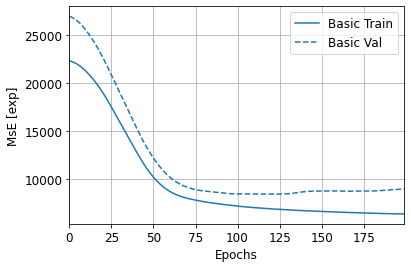

In [126]:
plotter.plot({'Basic': history}, metric = "mse")
# plt.ylim([0, 10])
plt.ylabel('MsE [exp]')


# Prediction model

In [15]:
# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

In [16]:
def metric_result(pred, test):
    print("explained_variance_score:", explained_variance_score(pred,test))    
    print("max_error:\t\t ", max_error(pred,test))    #max(abs(pred-test))
    print("mean_absolute_error:\t ", mean_absolute_error(pred,test))
    print("mean_squared_error:\t ", mean_squared_error(pred,test))    
#     print("mean_squared_log_error:\t", mean_squared_log_error(pred,test))
    print("root mean squared error", np.sqrt(mean_squared_error(pred,test)))

In [17]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

-0.13413970919792506

In [18]:
pred = reg.predict(X_test)

In [19]:
pd.DataFrame(zip(pred, y_test), columns=['pred','ground truth']).head(20)

,pred,ground truth
0,[57.24784928376407],[98.0]
1,[129.73851604162016],[100.0]
2,[133.2273115284189],[230.0]
3,[42.697821897880914],[116.0]
4,[71.61050746056287],[35.0]
5,[58.55375260970439],[50.0]
6,[81.48085829226628],[180.0]
7,[122.80905037717966],[50.0]
8,[65.2475791326607],[49.0]
9,[66.92849139335596],[28.0]


In [20]:
metric_result(y_test, pred)

explained_variance_score: -0.13044771887577356
max_error:		  297.1378659424799
mean_absolute_error:	  78.95383471166213
mean_squared_error:	  9801.651106357253
root mean squared error 99.00328836133299


In [21]:
import statsmodels.api as sm
X = np.append(arr = np.ones((len(X),1)).astype(int), values = X, axis = 1)

In [22]:
X_opt = X[:,[0,1,2,3,4,5,6,7]]
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     4.617
Date:                Sat, 13 Jun 2020   Prob (F-statistic):           0.000141
Time:                        21:25:49   Log-Likelihood:                -720.27
No. Observations:                 122   AIC:                             1457.
Df Residuals:                     114   BIC:                             1479.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        123.5902      8.304     14.883      0.000     107.139     140.041
x1           -39.9832     13.760     -2.906      0.004     -67.242     -12.724
x2             0.8400     18.166      0.046      0.963     -35.146      36.826
x3           -10.0190     18.868     -0.531      0.596     -47.397      27.359
x4            -2.3161     11.598     -0.200      0.842     -25.292      20.660
x5           -45.4523      9.943     -4.571      0.000     -65.149     -25.756
x6           -23.9739     11.355     -2.111      0.037     -46.468      -1.480
x7           -16.1251     13.129     -1.228      0.222     -42.134       9.884
==============================================================================
Omnibus:                        6.768   Durbin-Watson:                   0.387
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.830
Skew:                           0.543   Prob(JB):                       0.0329
Kurtosis:                       2.593   Cond. No.                         5.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
X_opt = X[:,[0,1,3,4,5,6,7]]
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     5.433
Date:                Sat, 13 Jun 2020   Prob (F-statistic):           5.61e-05
Time:                        21:25:49   Log-Likelihood:                -720.27
No. Observations:                 122   AIC:                             1455.
Df Residuals:                     115   BIC:                             1474.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        123.5902      8.268     14.948      0.000     107.212     139.968
x1           -39.9171     13.626     -2.929      0.004     -66.908     -12.926
x2            -9.2767      9.873     -0.940      0.349     -28.834      10.280
x3            -2.1926     11.237     -0.195      0.846     -24.452      20.067
x4           -45.3872      9.799     -4.632      0.000     -64.798     -25.976
x5           -24.0428     11.207     -2.145      0.034     -46.243      -1.843
x6           -16.0423     12.950     -1.239      0.218     -41.694       9.609
==============================================================================
Omnibus:                        6.795   Durbin-Watson:                   0.387
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.846
Skew:                           0.543   Prob(JB):                       0.0326
Kurtosis:                       2.588   Cond. No.                         3.39
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
X_opt = X[:,[0,1,3,5,6,7]]
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     6.567
Date:                Mon, 08 Jun 2020   Prob (F-statistic):           2.05e-05
Time:                        12:19:43   Log-Likelihood:                -720.29
No. Observations:                 122   AIC:                             1453.
Df Residuals:                     116   BIC:                             1469.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        123.5902      8.234     15.010      0.000     107.282     139.898
x1           -38.4644     11.365     -3.385      0.001     -60.973     -15.955
x2            -9.7224      9.565     -1.016      0.312     -28.668       9.223
x3           -44.6079      8.911     -5.006      0.000     -62.258     -26.958
x4           -23.8265     11.106     -2.145      0.034     -45.824      -1.829
x5           -15.9832     12.893     -1.240      0.218     -41.519       9.552
==============================================================================
Omnibus:                        6.694   Durbin-Watson:                   0.385
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                6.792
Skew:                           0.544   Prob(JB):                       0.0335
Kurtosis:                       2.608   Cond. No.                         2.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
X_opt = X[:,[0,1,5,6,7]]
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     7.948
Date:                Mon, 08 Jun 2020   Prob (F-statistic):           1.06e-05
Time:                        12:19:44   Log-Likelihood:                -720.83
No. Observations:                 122   AIC:                             1452.
Df Residuals:                     117   BIC:                             1466.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        123.5902      8.235     15.008      0.000     107.281     139.899
x1           -35.2323     10.912     -3.229      0.002     -56.843     -13.621
x2           -43.9253      8.887     -4.943      0.000     -61.526     -26.325
x3           -28.7150     10.012     -2.868      0.005     -48.544      -8.887
x4           -10.4581     11.692     -0.894      0.373     -33.614      12.698
==============================================================================
Omnibus:                        7.063   Durbin-Watson:                   0.367
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                7.389
Skew:                           0.591   Prob(JB):                       0.0249
Kurtosis:                       2.762   Cond. No.                         2.51
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
X_opt = X[:,[0,1,5,6]]
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     10.35
Date:                Mon, 08 Jun 2020   Prob (F-statistic):           4.25e-06
Time:                        12:19:45   Log-Likelihood:                -721.24
No. Observations:                 122   AIC:                             1450.
Df Residuals:                     118   BIC:                             1462.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        123.5902      8.228     15.021      0.000     107.296     139.884
x1           -30.0628      9.248     -3.251      0.002     -48.377     -11.749
x2           -42.5575      8.747     -4.865      0.000     -59.879     -25.236
x3           -32.5744      9.027     -3.609      0.000     -50.450     -14.699
==============================================================================
Omnibus:                        6.824   Durbin-Watson:                   0.349
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                7.044
Skew:                           0.585   Prob(JB):                       0.0295
Kurtosis:                       2.872   Cond. No.                         1.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(X_opt, y, test_size=0.5, random_state=5)


In [60]:
reg = LinearRegression().fit(X_train_opt, y_train_opt)
reg.score(X_test_opt, y_test_opt)

0.2012100513178291

In [61]:
pred = reg.predict(X_test_opt)

In [62]:
metric_result(pred, y_test_opt)

explained_variance_score: -1.3013085362078174
max_error:		  198.85626710254772
mean_absolute_error:	  70.9124975006001
mean_squared_error:	  6903.435547446554
root mean squared error 83.08691562121291


# ensemble

In [29]:
# Setup cross validation folds
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [30]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)


In [31]:
# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

In [32]:
# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

In [33]:
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)


In [34]:

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [35]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X_opt):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [36]:
scores = {}

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

lightgbm: 105.5540 (7.2050)


In [37]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

[12:20:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:16

In [38]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 106.5440 (23.1716)


In [39]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 93.1884 (8.3905)


In [40]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 96.9238 (6.5521)


In [41]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 113.8497 (2.4930)


In [42]:
score = cv_rmse(stack_gen)
print("stack: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['stack'] = (score.mean(), score.std())

[12:21:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:21:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:21:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:21:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:21:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:21:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:16

[12:25:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:26:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:16

In [43]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

stack_gen
[12:27:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression

In [44]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

lightgbm


In [45]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

xgboost
[12:29:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.


In [46]:
print('Svr')
svr_model_full_data = svr.fit(X, y)

Svr


In [47]:
print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

Ridge


In [48]:
print('RandomForest')
rf_model_full_data = rf.fit(X, y)

RandomForest


In [49]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

GradientBoosting


In [50]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.1 * ridge_model_full_data.predict(X).reshape(-1)) + \
            (0.2 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))

In [51]:
scores

{'lgb': (105.5540065746255, 7.2050119549097245),
 'xgb': (107.90898966265654, 4.1224496656850595),
 'svr': (106.54395933809178, 23.17158049405887),
 'ridge': (93.1883653929481, 8.390473080808338),
 'rf': (96.92377121581508, 6.5521255784792425),
 'gbr': (113.84972951356102, 2.4929691290765383),
 'stack': (101.47528218224365, 5.570311899992882)}

In [52]:
# Get final precitions from the blended model
blended_score = rmsle(y, blended_predictions(X))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
57.146513210302736


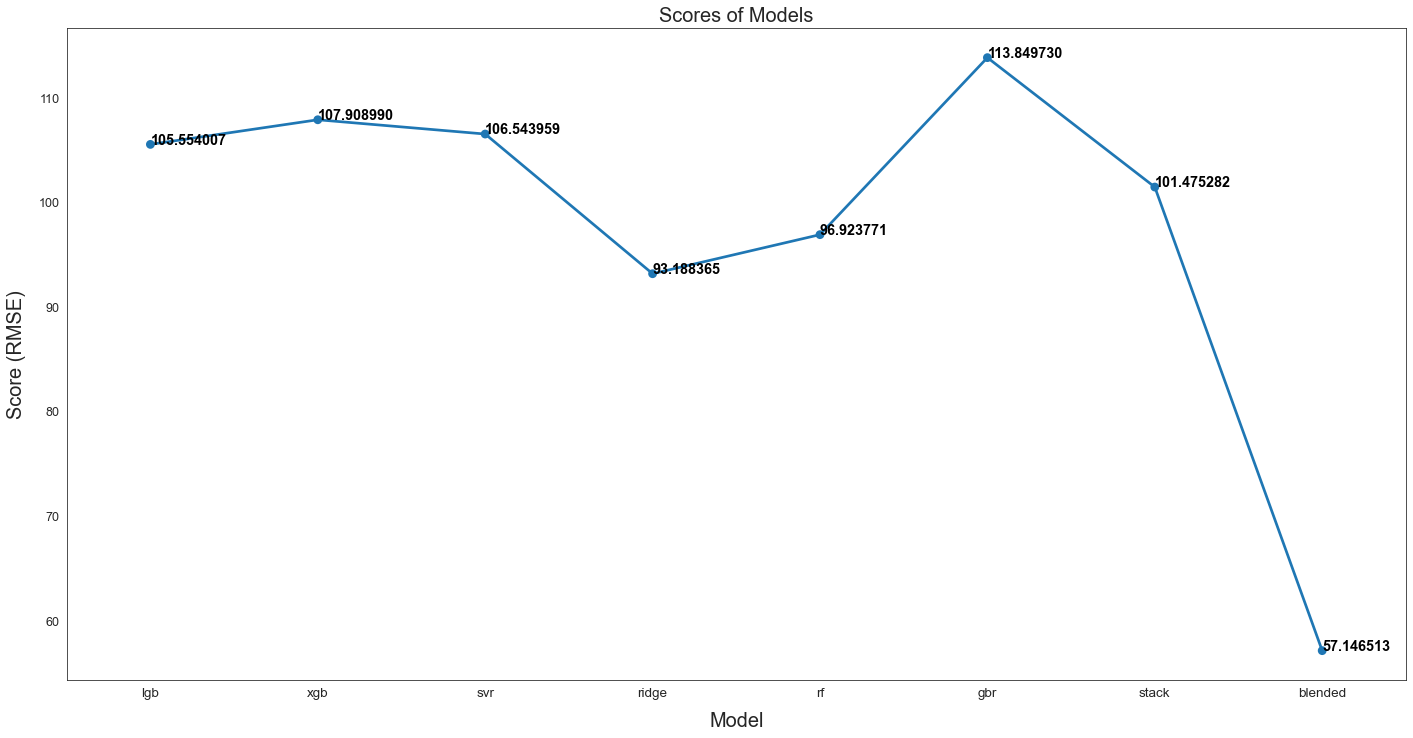

In [53]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()


In [ ]:
sum|a-b|/n